# Предсказание температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. В данной работе будет построена модель, которая предскажет температуру стали.

## 0. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

## 1. Изучение данных

In [4]:
data_arc = pd.read_csv('data_arc.csv') # данные об электродах;
data_bulk = pd.read_csv('data_bulk.csv') # данные о подаче сыпучих материалов (объём);
data_bulk_time = pd.read_csv('data_bulk_time.csv') # данные о подаче сыпучих материалов (время);
data_gas = pd.read_csv('data_gas.csv') # данные о продувке сплава газом;
data_temp = pd.read_csv('data_temp.csv') # результаты измерения температуры;
data_wire = pd.read_csv('data_wire.csv') # данные о проволочных материалах (объём);
data_wire_time = pd.read_csv('data_wire_time.csv') # данные о проволочных материалах (время).

### 1.1 data_arc

In [3]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
data_arc.duplicated().sum()

0

Пропусков нет, дубликатов нет.  
Из этих данных, вероятно, можно будет использовать значения реактивных мощностей.

In [6]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


### 1.2 data_bulk

In [7]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [8]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [9]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Таблица сильно неоднородна. Значительное количество пропусков.  
Стоит принять решение, нужны ли вообще эти данные для построения модели.

### 1.3 data_bulk_time

In [10]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [11]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Эти данные напрямую относятся к data_bulk. 

### 1.4 data_gas

In [12]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [13]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [14]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [15]:
data_gas.duplicated().sum()

0

Дубликатов нет, пропусков нет.

### 1.5 data_temp

In [16]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [17]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [18]:
data_temp.duplicated().sum()

0

Дубликатов нет.

В данных есть пропуски. Необходимо будет провести дополнительное исследование этих данных и принять решение об обработке пропусков.

### 1.6 data_wire

In [19]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [20]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Пропущенные значения означают, что какую-то проволоку не добавляли.

### 1.7 data_wire_time

In [22]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [23]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Эти данные относятся к таблице data_wire.

## 2. Исследовательский анализ

Приведем данные с датой в таблице **data_arc** к типу datetime

In [24]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])

In [25]:
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [26]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Построим распределение столбца **Активная мощность**

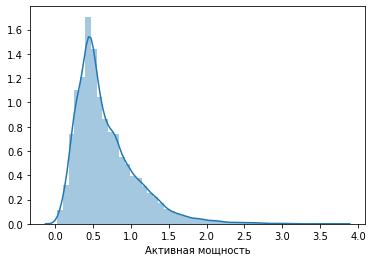

In [27]:
sns.distplot(data_arc['Активная мощность'])
plt.show()

Распределение похоже на нормальное, немного скошено вправо.

Пострим распределение для **data_gas**

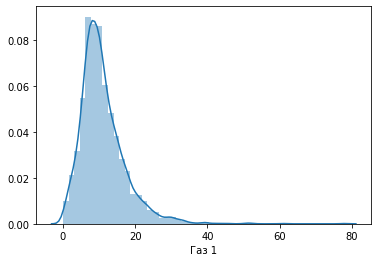

In [28]:
sns.distplot(data_gas['Газ 1'])
plt.show()

Приведем значения столбца со временем таблицы **data_temp** к типу datetime

In [29]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

In [30]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Построим распределение столбца "Температура"

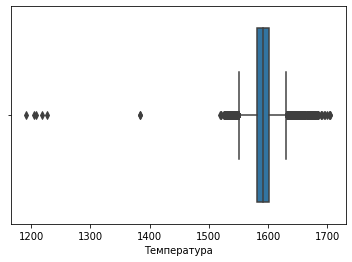

In [31]:
sns.boxplot(data_temp['Температура'])

Основное количество данных данных лежит в достаточно узком диапазоне. Аномальных значений температуры совсем мало по сравнению со всем количеством данных.  
Удалим пропущеные значения целевого признака.

In [32]:
data_temp.dropna(inplace=True)

In [33]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
key             13006 non-null int64
Время замера    13006 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


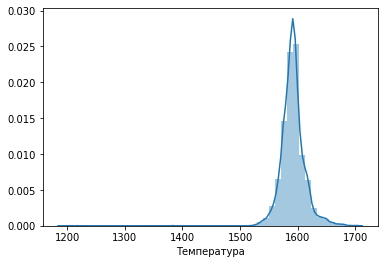

In [34]:
sns.distplot(data_temp['Температура'])
plt.show()

In [35]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
key             13006 non-null int64
Время замера    13006 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


Пропуски обработаны.

# 3. Подготовка признаков

**решить, нужно ли заполнять пропуски в целевом признаке - температуре**

Создадим итоговый датасет, на котором будем обучать модели.  
Он будет основан на наборе данных **data_temp**. 

Избавимся от промежуточных температур. Будем использовать только конечную.

In [36]:
data_temp.head(15)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [37]:
data = data_temp.drop(['Время замера'], axis=1) # удалим столбец со временем

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 2 columns):
key            13006 non-null int64
Температура    13006 non-null float64
dtypes: float64(1), int64(1)
memory usage: 304.8 KB


In [39]:
# сгруппируем оставшийся датасет по key и возьмем последний элемент (конечная температура)
data_last = data.groupby(['key'], axis=0, as_index=False).last() # конечная температура этапа
data_first = data.groupby(['key'], axis=0, as_index=False).first() # начальная температура этапа                                           

In [40]:
data_last.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 2 columns):
key            3216 non-null int64
Температура    3216 non-null float64
dtypes: float64(1), int64(1)
memory usage: 75.4 KB


In [41]:
data_first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 2 columns):
key            3216 non-null int64
Температура    3216 non-null float64
dtypes: float64(1), int64(1)
memory usage: 75.4 KB


In [42]:
# создадим датасет, состоящий из начальной температуры этапа, конечной и номера этапа
data = pd.merge(data_first, data_last, how ='inner', on ='key') 

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 3 columns):
key              3216 non-null int64
Температура_x    3216 non-null float64
Температура_y    3216 non-null float64
dtypes: float64(2), int64(1)
memory usage: 100.5 KB


In [44]:
data.head()

,key,Температура_x,Температура_y
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


Сравним начальные и конечные температуры каждого этапа. Если они одинаковые, то не будем брать их в расчеты и удалим из датасета эти значения.

In [46]:
data['temp'] = data['Температура_x'] == data['Температура_y']

In [47]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 4 columns):
key              3216 non-null int64
Температура_x    3216 non-null float64
Температура_y    3216 non-null float64
temp             3216 non-null bool
dtypes: bool(1), float64(2), int64(1)
memory usage: 103.6 KB


In [48]:
data['temp'].sum()

783

Получили 783 значения с одинаковыми начальными и конечными температурами. Удалим их из набора.

In [49]:
data = data[data['temp'] == False]

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 0 to 2476
Data columns (total 4 columns):
key              2433 non-null int64
Температура_x    2433 non-null float64
Температура_y    2433 non-null float64
temp             2433 non-null bool
dtypes: bool(1), float64(2), int64(1)
memory usage: 78.4 KB


Удалим ненужный больше столбец temp и переименуем "Температуры"

In [51]:
data = data.drop('temp', axis=1)

In [52]:
data.columns=['key', 'temp_1', 'temp_2']

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 0 to 2476
Data columns (total 3 columns):
key       2433 non-null int64
temp_1    2433 non-null float64
temp_2    2433 non-null float64
dtypes: float64(2), int64(1)
memory usage: 76.0 KB


Заполним пропущенные значения в таблице data_wire нулями (т.к. пропуск означает, сто этой проволоки не добавляли).

In [54]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [55]:
data_wire = data_wire.fillna(0)

In [58]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3081 non-null float64
Wire 2    3081 non-null float64
Wire 3    3081 non-null float64
Wire 4    3081 non-null float64
Wire 5    3081 non-null float64
Wire 6    3081 non-null float64
Wire 7    3081 non-null float64
Wire 8    3081 non-null float64
Wire 9    3081 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Добавим данные из получившегося датасета ***data_wire** в **data**

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 0 to 2476
Data columns (total 3 columns):
key       2433 non-null int64
temp_1    2433 non-null float64
temp_2    2433 non-null float64
dtypes: float64(2), int64(1)
memory usage: 76.0 KB


In [60]:
data_1 = data.merge(data_wire, on='key', how='inner')

In [61]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2336 entries, 0 to 2335
Data columns (total 12 columns):
key       2336 non-null int64
temp_1    2336 non-null float64
temp_2    2336 non-null float64
Wire 1    2336 non-null float64
Wire 2    2336 non-null float64
Wire 3    2336 non-null float64
Wire 4    2336 non-null float64
Wire 5    2336 non-null float64
Wire 6    2336 non-null float64
Wire 7    2336 non-null float64
Wire 8    2336 non-null float64
Wire 9    2336 non-null float64
dtypes: float64(11), int64(1)
memory usage: 237.2 KB


Выделим признаки из столбца **data_arc**

In [62]:
data = data_1

In [63]:
data_arc.head(15)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Посчитаем время нагрева дугой для каждого этапа в минутах

In [64]:
data_arc['time_delta'] = ((data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']) \
                          / np.timedelta64(1, 'm')).astype('int')                          

In [65]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time_delta
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,3
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,3
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,6
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,2


Сгруппируем данные по ключу и рассчитаем суммарную мощность общее время.  
Предварительно составим датасет из интересующих нас величин.

In [66]:
data_arc_new = data_arc[['key', 'Активная мощность', 'time_delta']]

In [67]:
data_arc_group = data_arc_new.groupby(['key'], axis=0, as_index=False).sum()

In [68]:
data_arc_group.head()

,key,Активная мощность,time_delta
0,1,4.878147,16
1,2,3.052598,12
2,3,2.525882,9
3,4,3.209250,10
4,5,3.347173,13


In [69]:
data_arc_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 3 columns):
key                  3214 non-null int64
Активная мощность    3214 non-null float64
time_delta           3214 non-null int64
dtypes: float64(1), int64(2)
memory usage: 100.4 KB


Добавим полученные столбцы в **data**.

In [70]:
data_2 = data.merge(data_arc_group, on='key', how='inner')

In [71]:
data_2.head()

,key,temp_1,temp_2,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Активная мощность,time_delta
0,1,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.878147,16
1,2,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.052598,12
2,3,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.525882,9
3,4,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.209250,10
4,5,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.347173,13


In [72]:
data = data_2

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2336 entries, 0 to 2335
Data columns (total 14 columns):
key                  2336 non-null int64
temp_1               2336 non-null float64
temp_2               2336 non-null float64
Wire 1               2336 non-null float64
Wire 2               2336 non-null float64
Wire 3               2336 non-null float64
Wire 4               2336 non-null float64
Wire 5               2336 non-null float64
Wire 6               2336 non-null float64
Wire 7               2336 non-null float64
Wire 8               2336 non-null float64
Wire 9               2336 non-null float64
Активная мощность    2336 non-null float64
time_delta           2336 non-null int64
dtypes: float64(12), int64(2)
memory usage: 273.8 KB


Выделим полезные данные из таблицы **data_bulk**

In [74]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


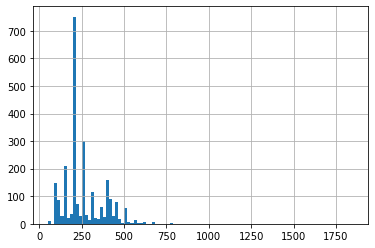

In [75]:
data_bulk['Bulk 12'].hist(bins=100)

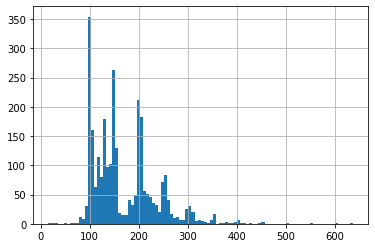

In [76]:
data_bulk['Bulk 14'].hist(bins=100)

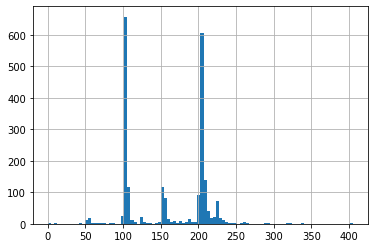

In [77]:
data_bulk['Bulk 15'].hist(bins=100)

Пропущенные значения говорят о том, что примеси не добавляли. Заменим их нулями.

In [78]:
data_bulk = data_bulk.fillna(0)

In [79]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     3129 non-null float64
Bulk 2     3129 non-null float64
Bulk 3     3129 non-null float64
Bulk 4     3129 non-null float64
Bulk 5     3129 non-null float64
Bulk 6     3129 non-null float64
Bulk 7     3129 non-null float64
Bulk 8     3129 non-null float64
Bulk 9     3129 non-null float64
Bulk 10    3129 non-null float64
Bulk 11    3129 non-null float64
Bulk 12    3129 non-null float64
Bulk 13    3129 non-null float64
Bulk 14    3129 non-null float64
Bulk 15    3129 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Добавим эти значения в итоговый датасет

In [80]:
data_5 = data.merge(data_bulk, on='key', how='inner')

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2336 entries, 0 to 2335
Data columns (total 14 columns):
key                  2336 non-null int64
temp_1               2336 non-null float64
temp_2               2336 non-null float64
Wire 1               2336 non-null float64
Wire 2               2336 non-null float64
Wire 3               2336 non-null float64
Wire 4               2336 non-null float64
Wire 5               2336 non-null float64
Wire 6               2336 non-null float64
Wire 7               2336 non-null float64
Wire 8               2336 non-null float64
Wire 9               2336 non-null float64
Активная мощность    2336 non-null float64
time_delta           2336 non-null int64
dtypes: float64(12), int64(2)
memory usage: 273.8 KB


In [82]:
data_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2295 entries, 0 to 2294
Data columns (total 29 columns):
key                  2295 non-null int64
temp_1               2295 non-null float64
temp_2               2295 non-null float64
Wire 1               2295 non-null float64
Wire 2               2295 non-null float64
Wire 3               2295 non-null float64
Wire 4               2295 non-null float64
Wire 5               2295 non-null float64
Wire 6               2295 non-null float64
Wire 7               2295 non-null float64
Wire 8               2295 non-null float64
Wire 9               2295 non-null float64
Активная мощность    2295 non-null float64
time_delta           2295 non-null int64
Bulk 1               2295 non-null float64
Bulk 2               2295 non-null float64
Bulk 3               2295 non-null float64
Bulk 4               2295 non-null float64
Bulk 5               2295 non-null float64
Bulk 6               2295 non-null float64
Bulk 7               2295 non-null fl

In [83]:
data = data_5

Посмотрим данные по таблице **data_gas**

In [84]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [85]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [86]:
data_7 = data.merge(data_gas, on='key', how='inner')

In [87]:
data = data_7

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 30 columns):
key                  2293 non-null int64
temp_1               2293 non-null float64
temp_2               2293 non-null float64
Wire 1               2293 non-null float64
Wire 2               2293 non-null float64
Wire 3               2293 non-null float64
Wire 4               2293 non-null float64
Wire 5               2293 non-null float64
Wire 6               2293 non-null float64
Wire 7               2293 non-null float64
Wire 8               2293 non-null float64
Wire 9               2293 non-null float64
Активная мощность    2293 non-null float64
time_delta           2293 non-null int64
Bulk 1               2293 non-null float64
Bulk 2               2293 non-null float64
Bulk 3               2293 non-null float64
Bulk 4               2293 non-null float64
Bulk 5               2293 non-null float64
Bulk 6               2293 non-null float64
Bulk 7               2293 non-null fl

In [89]:
data.head()

,key,temp_1,temp_2,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692


Переименуем названия столбцов для удобства.

In [90]:
#data.columns = ['kye', 'temp', 'wire_1', 'wire_2', 'act_pow', 'time_delta', 'gas']
data = data.rename(columns={'Активная мощность': 'act_pow', 'Газ 1': 'gas'})

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 30 columns):
key           2293 non-null int64
temp_1        2293 non-null float64
temp_2        2293 non-null float64
Wire 1        2293 non-null float64
Wire 2        2293 non-null float64
Wire 3        2293 non-null float64
Wire 4        2293 non-null float64
Wire 5        2293 non-null float64
Wire 6        2293 non-null float64
Wire 7        2293 non-null float64
Wire 8        2293 non-null float64
Wire 9        2293 non-null float64
act_pow       2293 non-null float64
time_delta    2293 non-null int64
Bulk 1        2293 non-null float64
Bulk 2        2293 non-null float64
Bulk 3        2293 non-null float64
Bulk 4        2293 non-null float64
Bulk 5        2293 non-null float64
Bulk 6        2293 non-null float64
Bulk 7        2293 non-null float64
Bulk 8        2293 non-null float64
Bulk 9        2293 non-null float64
Bulk 10       2293 non-null float64
Bulk 11       2293 non-null float

In [93]:
pd.set_option('display.max_columns', 150)
data.head(3)

,key,temp_1,temp_2,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,act_pow,time_delta,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas
0,1,1571.0,1613.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.878147,16,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.052598,12,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.525882,9,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793


## Изучение итогового набора данных.

Построим матрицу корреляций

In [94]:
corr = data.corr()
corr

,key,temp_1,temp_2,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,act_pow,time_delta,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas
key,1.000000,-0.021206,-0.101522,-0.016550,0.045248,-0.027068,0.049820,NaN,-0.007906,0.037370,-0.036007,0.021781,-0.030370,-0.036031,-0.074087,-0.005988,-0.005752,-0.027059,0.035872,0.007876,0.052941,0.015674,-0.039752,0.062053,0.038036,0.026805,-0.015651,-0.112169,-0.044593,-0.044429
temp_1,-0.021206,1.000000,0.247758,0.207442,-0.084844,0.000232,0.065347,NaN,0.020325,0.044967,-0.023055,0.004645,-0.351962,-0.314345,0.073896,0.120302,-0.104162,0.142999,0.068947,-0.095032,0.075107,-0.009264,-0.026013,0.035791,-0.087717,-0.061164,0.018910,-0.132640,-0.041960,0.037686
temp_2,-0.101522,0.247758,1.000000,0.313493,-0.206883,-0.048049,-0.161311,NaN,-0.084906,-0.138618,-0.010898,-0.027792,0.288620,0.284838,-0.074559,-0.083292,-0.036533,0.184636,-0.028678,-0.179633,-0.108353,-0.026855,-0.016259,0.061691,-0.110517,0.265241,-0.011054,0.113165,0.266348,0.058063
Wire 1,-0.016550,0.207442,0.313493,1.000000,-0.067045,0.038305,-0.142777,NaN,-0.128731,-0.067874,0.017340,0.021205,0.048517,0.041041,0.015794,-0.170400,0.040465,0.295424,-0.013550,-0.233375,-0.144045,0.034843,0.022732,0.062481,-0.115356,0.170117,0.039669,-0.054473,0.120059,0.115629
Wire 2,0.045248,-0.084844,-0.206883,-0.067045,1.000000,0.093985,-0.034043,NaN,-0.059201,-0.016337,0.069245,0.213453,0.055369,0.052472,-0.011764,-0.039388,0.096544,-0.266983,-0.014188,0.203061,-0.000830,0.018900,0.066697,-0.104179,0.066725,-0.100186,-0.001620,0.035552,-0.100112,0.103664
Wire 3,-0.027068,0.000232,-0.048049,0.038305,0.093985,1.000000,0.169716,NaN,0.183289,0.100347,-0.008319,-0.010794,0.035263,0.025101,0.020315,0.223100,0.005347,-0.039247,0.070718,-0.046949,0.156529,-0.002438,-0.008413,-0.028319,-0.021753,-0.121489,-0.008822,-0.009236,-0.119141,0.103659
Wire 4,0.049820,0.065347,-0.161311,-0.142777,-0.034043,0.169716,1.000000,NaN,0.445905,0.602957,-0.004630,-0.006007,0.047614,0.038927,0.147235,0.699320,-0.040974,0.034843,0.262681,-0.026155,0.740555,-0.001357,-0.004682,-0.015760,-0.012106,-0.086222,-0.004910,-0.122715,-0.092115,0.146140
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,-0.007906,0.020325,-0.084906,-0.128731,-0.059201,0.183289,0.445905,NaN,1.000000,0.302720,-0.008091,-0.010498,0.053100,0.036497,0.149481,0.558837,0.006699,-0.011236,0.204653,-0.020574,0.456046,-0.002371,-0.008182,-0.018076,0.009367,-0.043221,-0.008580,-0.053012,-0.032889,0.108406
Wire 7,0.037370,0.044967,-0.138618,-0.067874,-0.016337,0.100347,0.602957,NaN,0.302720,1.000000,-0.002222,-0.002883,0.019614,0.015675,0.083979,0.431723,-0.019663,0.034164,0.172104,-0.012551,0.372234,-0.000651,-0.002247,-0.007563,-0.005810,-0.041377,-0.002356,-0.058889,-0.044205,0.079361


Построим тепловую диагармму корреляций.

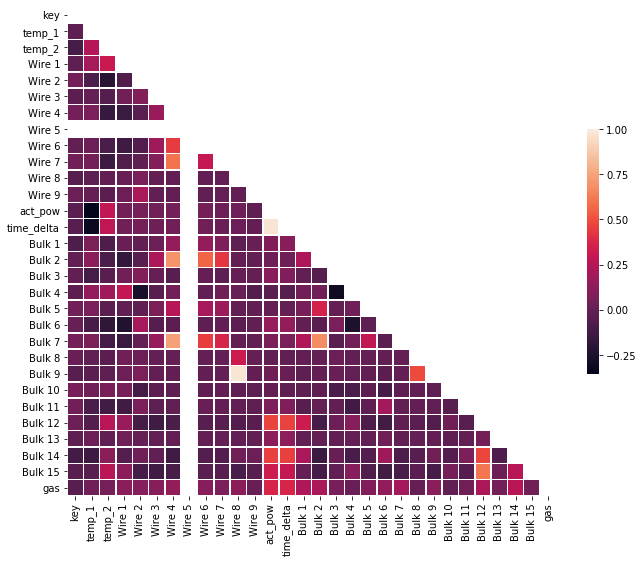

In [95]:

# Создадим маску для верхнего треугольника
mask = np.triu(np.ones_like(corr, dtype=bool))

# Зададим параметры фигуры
f, ax = plt.subplots(figsize=(11, 9))

# Строим диаграмму
sns.heatmap(corr, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Наблюдается сильная корреляция между значениями time_delta и act_pow. Чем больше время нагрева, тем выше активная мощность.  
Избавимся от столбца **time_delta**

In [96]:
data = data.drop('time_delta', axis=1)

In [97]:
data['Wire 5'].sum()

0.0

Столбец Wire 5 состоит из одних нулей. Никакой полезной информации не несет.

In [98]:
data = data.drop('Wire 5', axis=1)

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 28 columns):
key        2293 non-null int64
temp_1     2293 non-null float64
temp_2     2293 non-null float64
Wire 1     2293 non-null float64
Wire 2     2293 non-null float64
Wire 3     2293 non-null float64
Wire 4     2293 non-null float64
Wire 6     2293 non-null float64
Wire 7     2293 non-null float64
Wire 8     2293 non-null float64
Wire 9     2293 non-null float64
act_pow    2293 non-null float64
Bulk 1     2293 non-null float64
Bulk 2     2293 non-null float64
Bulk 3     2293 non-null float64
Bulk 4     2293 non-null float64
Bulk 5     2293 non-null float64
Bulk 6     2293 non-null float64
Bulk 7     2293 non-null float64
Bulk 8     2293 non-null float64
Bulk 9     2293 non-null float64
Bulk 10    2293 non-null float64
Bulk 11    2293 non-null float64
Bulk 12    2293 non-null float64
Bulk 13    2293 non-null float64
Bulk 14    2293 non-null float64
Bulk 15    2293 non-null float64
gas 

In [101]:
features = data.drop(['key', 'temp_2'], axis=1) # temp_2 - целевой признак (конечная температура)
target = data['temp_2']

Разобьем датасет на тренировочную и тестовую выборки.

In [102]:
features_train, features_test, target_train, target_test = train_test_split(
                                   features, target, test_size=0.3, random_state=24)

In [103]:
features_train.head(3)

,temp_1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,act_pow,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas
1790,1619.0,118.067040,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.595230,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.898433
2118,1577.0,157.116959,20.146879,0.0,0.0,0.0,0.0,0.0,0.0,5.063485,0.0,0.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,408.0,0.0,198.0,207.0,15.865326
2195,1532.0,94.436158,47.954398,0.0,0.0,0.0,0.0,0.0,0.0,6.668600,0.0,0.0,0.0,0.0,0.0,252.0,0.0,0.0,0.0,0.0,0.0,156.0,0.0,196.0,105.0,16.200934


In [104]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1605 entries, 1790 to 418
Data columns (total 26 columns):
temp_1     1605 non-null float64
Wire 1     1605 non-null float64
Wire 2     1605 non-null float64
Wire 3     1605 non-null float64
Wire 4     1605 non-null float64
Wire 6     1605 non-null float64
Wire 7     1605 non-null float64
Wire 8     1605 non-null float64
Wire 9     1605 non-null float64
act_pow    1605 non-null float64
Bulk 1     1605 non-null float64
Bulk 2     1605 non-null float64
Bulk 3     1605 non-null float64
Bulk 4     1605 non-null float64
Bulk 5     1605 non-null float64
Bulk 6     1605 non-null float64
Bulk 7     1605 non-null float64
Bulk 8     1605 non-null float64
Bulk 9     1605 non-null float64
Bulk 10    1605 non-null float64
Bulk 11    1605 non-null float64
Bulk 12    1605 non-null float64
Bulk 13    1605 non-null float64
Bulk 14    1605 non-null float64
Bulk 15    1605 non-null float64
gas        1605 non-null float64
dtypes: float64(26)
memory usage:

### Random Forest

In [105]:
model_rf = RandomForestRegressor(random_state=24)

In [106]:
params = { 'n_estimators': [10, 50, 100],
            'max_depth': [3, 4, 5],
            'min_samples_leaf': [3, 4, 5]
         }

In [107]:
gd_sr = GridSearchCV(estimator=model_rf,
                     param_grid=params,
                     scoring='neg_mean_absolute_error',
                     cv=5,
                     n_jobs=-1)

In [108]:
gd_sr.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=24,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5], 'min_sample

In [109]:
gd_sr.best_params_

{'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 100}

In [110]:
model_rf = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=4, random_state=24)

In [111]:
model_rf.fit(features_train, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=24, verbose=0,
                      warm_start=False)

In [112]:
importances = model_rf.feature_importances_

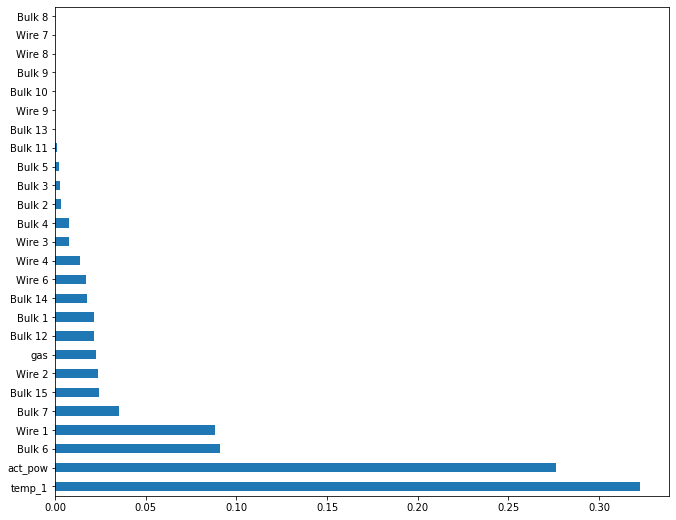

In [113]:
importances = pd.Series(model_rf.feature_importances_, index=features_train.columns)
plt.subplots(figsize=(11, 9))
importances.nlargest(len(features_train)).plot(kind='barh')
plt.show()

In [114]:
predictions = model_rf.predict(features_test)

In [115]:
mae_rf = mean_absolute_error(target_test, predictions)
mae_rf

6.382469358497778

Теперь обучим модель только на значимых признаках

In [116]:
features_train_main = features_train.drop(['Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 13', 'Bulk 11', 'Bulk 5', 'Bulk 3', 'Bulk 2', \
                                           'Wire 7', 'Wire 8', 'Wire 9', 'Wire 3'], axis=1)

In [117]:
features_test_main = features_test.drop(['Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 13', 'Bulk 11', 'Bulk 5', 'Bulk 3', 'Bulk 2', \
                                           'Wire 7', 'Wire 8', 'Wire 9', 'Wire 3'], axis=1)

In [118]:
model_rf.fit(features_train_main, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=24, verbose=0,
                      warm_start=False)

In [119]:
predictions = model_rf.predict(features_test_main)

In [120]:
mae_rf = mean_absolute_error(target_test, predictions)
mae_rf

6.372264665145246

### LightGBM

In [123]:
# Подбор параметров для модели LightGBM
score_func = make_scorer(mean_absolute_error, greater_is_better=False)

model_lgbm = lgb.LGBMRegressor( 
    boosting_type="gbdt",
    objective='regression',
    random_state=24, 
    n_estimators=50,
    num_leaves=30, 
    max_depth=8,
    learning_rate=0.5,
    )

params_opt = {'n_estimators': [100, 150, 200], 
              'num_leaves': [20, 40, 60],
              'max_depth': [10, 20, 30]
             }

gridSearchCV = GridSearchCV(estimator=model_lgbm, 
                            param_grid=params_opt, 
                            scoring=score_func)

gridSearchCV.fit(features_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.5,
                                     max_depth=8, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=50, n_jobs=-1, num_leaves=30,
                                     objective='regression', random_state=24,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [100, 150, 200],
                         'num_leaves': [20, 40, 60]},
         

In [124]:
gridSearchCV.best_params_

{'max_depth': 30, 'n_estimators': 100, 'num_leaves': 40}

Обучим модель с этими параметрами.

In [125]:
%%time
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'max_depth': 30, 
    'learning_rate': 0.5,
    'num_leaves': 40,
    'verbose': 0 
    }

n_estimators = 100

d_train = lgb.Dataset(features_train, label=target_train)
d_test = lgb.Dataset(features_test, label=target_test)
watchlist = [d_test]

model_lgb = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=10)

[10]	valid_0's l1: 6.47606
[20]	valid_0's l1: 6.62497
[30]	valid_0's l1: 6.75874
[40]	valid_0's l1: 6.82311
[50]	valid_0's l1: 6.85433
[60]	valid_0's l1: 6.88663
[70]	valid_0's l1: 6.90368
[80]	valid_0's l1: 6.92108
[90]	valid_0's l1: 6.93321
[100]	valid_0's l1: 6.93599
CPU times: user 412 ms, sys: 16 ms, total: 429 ms
Wall time: 226 ms


In [126]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature': X.columns})
    plt.figure(figsize=(40, 20))
    #sns.set(font_scale = 2)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=True)[0:num])
    plt.title('LightGBM Features')
    #plt.tight_layout()
    plt.show()

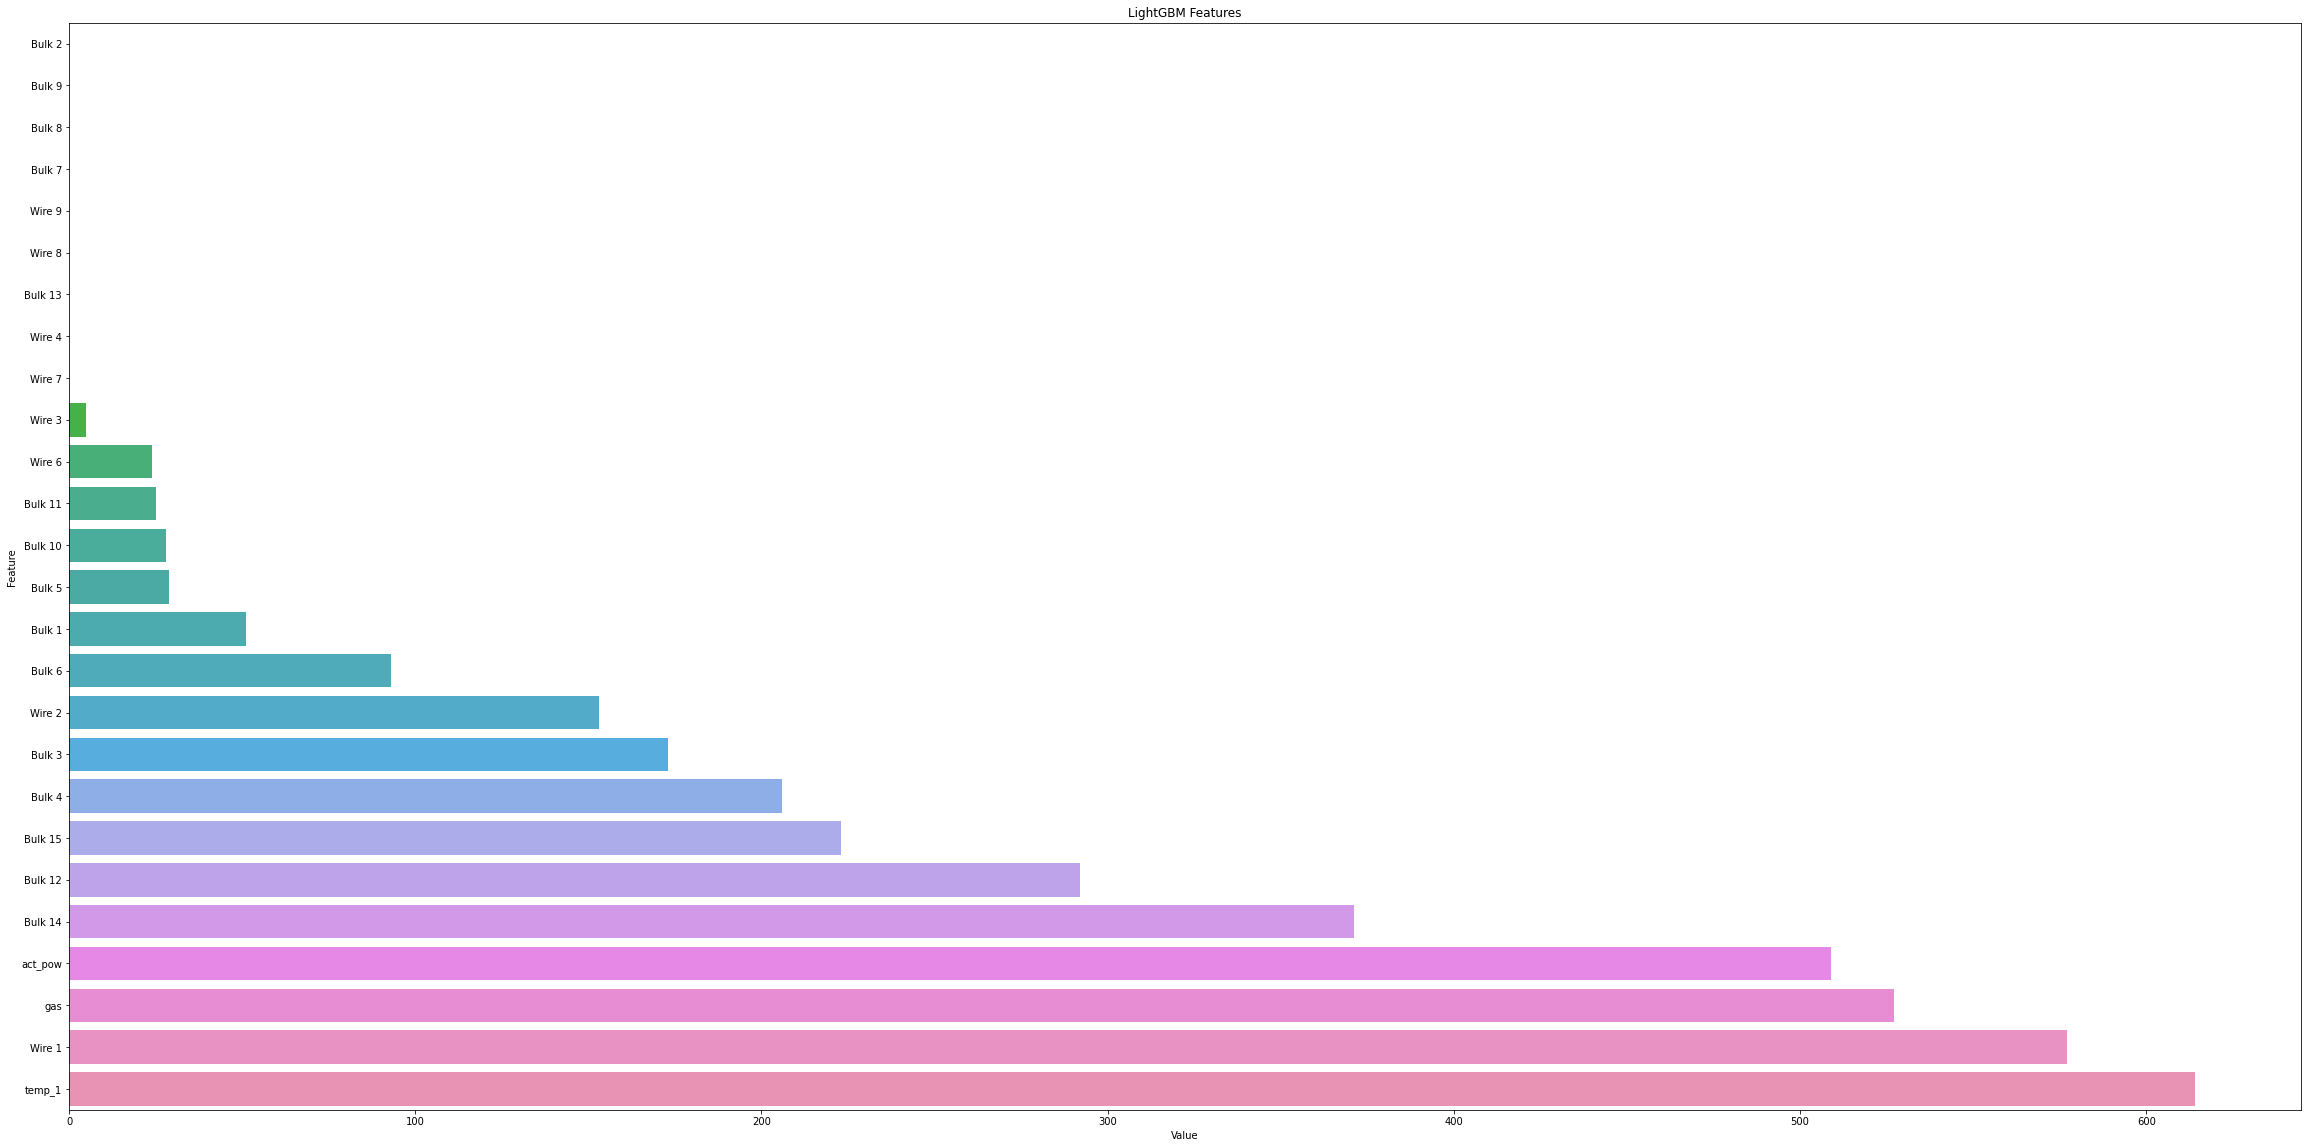

In [127]:
plotImp(model_lgb, features_train, num=26)

In [128]:
predictions = model_lgb.predict(features_test)
mae_lgb = mean_absolute_error(target_test, predictions)

In [129]:
mae_lgb

6.935994290570988

Обучим модель с наиболее важными признаками. 

In [130]:
features_train_main = features_train.drop(['Bulk 8', 'Bulk 9', 'Bulk 7', 'Bulk 13', \
                                           'Wire 7', 'Wire 8', 'Wire 9'], axis=1)

features_test_main = features_test.drop(['Bulk 8', 'Bulk 9', 'Bulk 7', 'Bulk 13', \
                                           'Wire 7', 'Wire 8', 'Wire 9'], axis=1)

In [131]:
%%time
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'max_depth': 30, 
    'learning_rate': 0.5,
    'num_leaves': 40,
    'verbose': 0 
    }

n_estimators = 100

d_train = lgb.Dataset(features_train_main, label=target_train)
d_test = lgb.Dataset(features_test_main, label=target_test)
watchlist = [d_test]

model_lgb = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=10)

[10]	valid_0's l1: 6.47606
[20]	valid_0's l1: 6.62497
[30]	valid_0's l1: 6.75874
[40]	valid_0's l1: 6.82311
[50]	valid_0's l1: 6.85433
[60]	valid_0's l1: 6.88663
[70]	valid_0's l1: 6.90368
[80]	valid_0's l1: 6.92108
[90]	valid_0's l1: 6.93321
[100]	valid_0's l1: 6.93599
CPU times: user 422 ms, sys: 21.9 ms, total: 444 ms
Wall time: 228 ms


In [132]:
predictions = model_lgb.predict(features_test_main)
mae_lgb = mean_absolute_error(target_test, predictions)

In [133]:
mae_lgb

6.935994290570988

### CatBoost

In [134]:
%%time
cv_dataset = Pool(data=features_train,
                  label=target_train
                  )

 
model_catboost = CatBoostRegressor(loss_function='MAE')
 
grid = {'learning_rate': [0.5, 0.01, 0.001],
        'depth': [6, 9, 12],
        'iterations': [50, 100, 200]}


 
grid_search_result = model_catboost.grid_search(
                                       grid, 
                                       X=cv_dataset,
                                       cv=3,
                                       plot=False)


bestTest = 8.444343871
bestIteration = 16

0:	loss: 8.4443439	best: 8.4443439 (0)	total: 266ms	remaining: 6.91s

bestTest = 966.2204462
bestIteration = 49

1:	loss: 966.2204462	best: 8.4443439 (0)	total: 445ms	remaining: 5.57s

bestTest = 1515.462003
bestIteration = 49

2:	loss: 1515.4620027	best: 8.4443439 (0)	total: 620ms	remaining: 4.96s

bestTest = 8.444343871
bestIteration = 16

3:	loss: 8.4443439	best: 8.4443439 (0)	total: 999ms	remaining: 5.75s

bestTest = 587.4487397
bestIteration = 99

4:	loss: 587.4487397	best: 8.4443439 (0)	total: 1.37s	remaining: 6.02s

bestTest = 1441.884264
bestIteration = 99

5:	loss: 1441.8842643	best: 8.4443439 (0)	total: 1.74s	remaining: 6.11s

bestTest = 8.444343871
bestIteration = 16

6:	loss: 8.4443439	best: 8.4443439 (0)	total: 2.46s	remaining: 7.04s

bestTest = 218.9302904
bestIteration = 199

7:	loss: 218.9302904	best: 8.4443439 (0)	total: 3.14s	remaining: 7.46s

bestTest = 1305.062027
bestIteration = 199

8:	loss: 1305.0620267	best: 8.4443439 

In [135]:
predictions = model_catboost.predict(features_test)

mae_cat = mean_absolute_error(target_test, predictions)

print(mae_cat)

6.433075377099301


In [136]:
feature_im = model_catboost.feature_importances_

In [137]:
feature_im

array([1.84569884e+01, 5.84517824e+00, 6.46541396e+00, 0.00000000e+00,
       4.18171087e-03, 1.28300681e+00, 0.00000000e+00, 0.00000000e+00,
       6.96214876e-03, 1.94712065e+01, 5.38951236e+00, 4.70081663e-04,
       3.31674013e+00, 2.89156170e+00, 1.35251984e-01, 6.56332882e+00,
       1.09130037e+00, 0.00000000e+00, 0.00000000e+00, 5.61639735e-01,
       1.01605867e+00, 8.79183536e+00, 7.98482638e-02, 4.81995531e+00,
       7.02594234e+00, 6.78361705e+00])

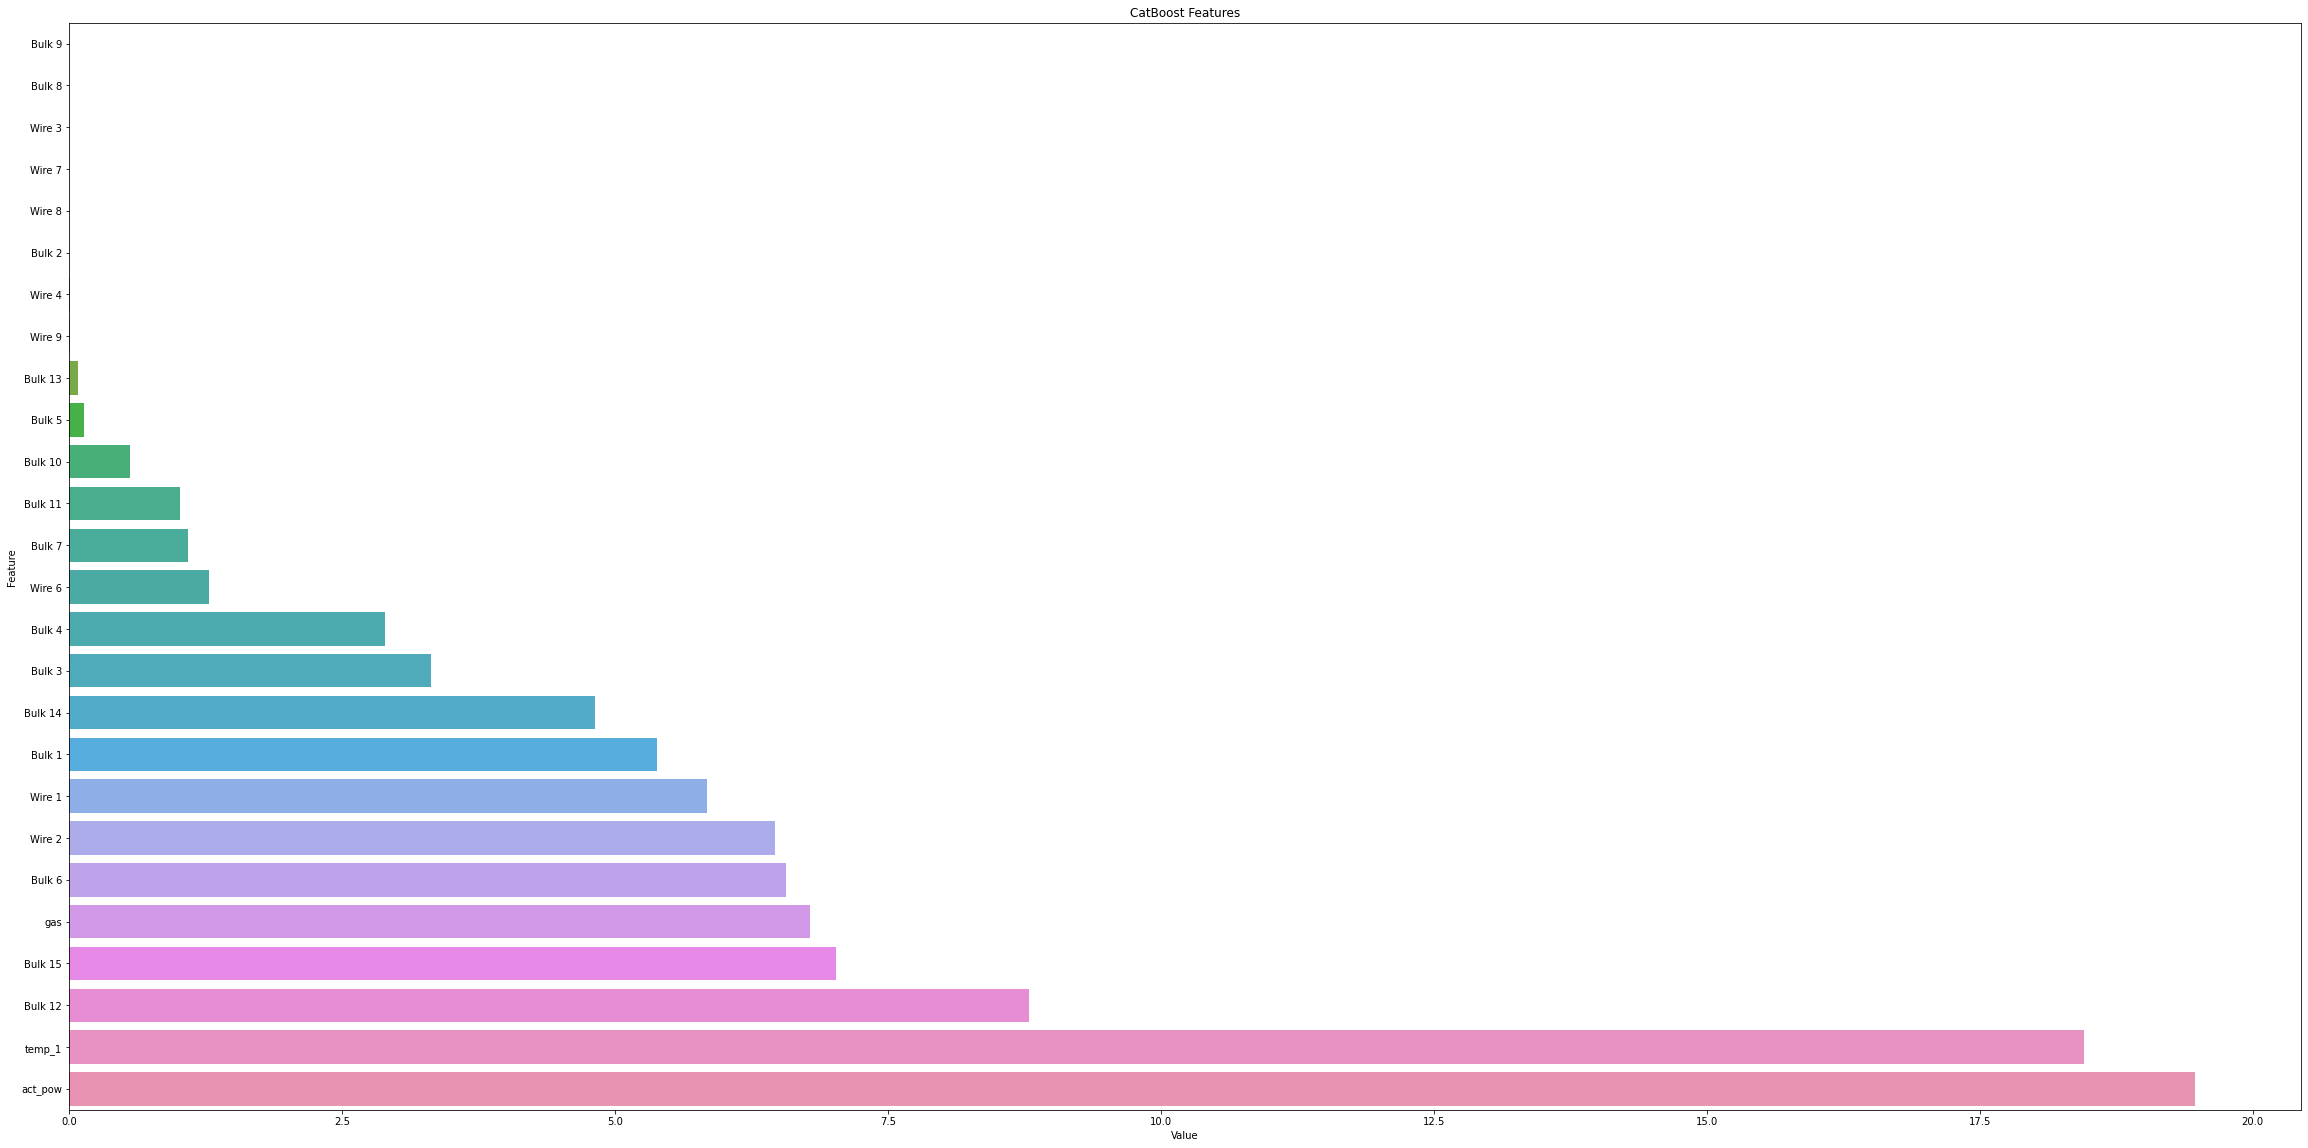

In [138]:
feature_imp = pd.DataFrame({'Value':model_catboost.feature_importances_,'Feature': features_train.columns})
plt.figure(figsize=(40, 20))
#sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=True)[0:26])
plt.title('CatBoost Features')
#plt.tight_layout()
plt.show()

In [139]:
features_train_main = features_train.drop(['Bulk 8', 'Bulk 9', 'Bulk 7', 'Bulk 13', 'Bulk 2', 'Bulk 5', 'Bulk 10', 'Bulk 11', 'Bulk 7', \
                                           'Wire 7', 'Wire 8', 'Wire 9', 'Wire 3', 'Wire 4', 'Wire 6'], axis=1)

features_test_main = features_test.drop(['Bulk 8', 'Bulk 9', 'Bulk 7', 'Bulk 13', 'Bulk 2', 'Bulk 5', 'Bulk 10', 'Bulk 11', 'Bulk 7', \
                                           'Wire 7', 'Wire 8', 'Wire 9', 'Wire 3', 'Wire 4', 'Wire 6'], axis=1)

In [140]:
%%time
cv_dataset = Pool(data=features_train_main,
                  label=target_train
                  )

 
model_catboost = CatBoostRegressor(loss_function='MAE')
 
grid = {'learning_rate': [0.5, 0.01, 0.001],
        'depth': [6, 9, 12],
        'iterations': [50, 100, 200]}


 
grid_search_result = model_catboost.grid_search(
                                       grid, 
                                       X=cv_dataset,
                                       cv=3,
                                       plot=False)


bestTest = 7.305403642
bestIteration = 17

0:	loss: 7.3054036	best: 7.3054036 (0)	total: 173ms	remaining: 4.5s

bestTest = 965.8430833
bestIteration = 49

1:	loss: 965.8430833	best: 7.3054036 (0)	total: 334ms	remaining: 4.18s

bestTest = 1515.423774
bestIteration = 49

2:	loss: 1515.4237742	best: 7.3054036 (0)	total: 506ms	remaining: 4.05s

bestTest = 7.305403642
bestIteration = 17

3:	loss: 7.3054036	best: 7.3054036 (0)	total: 838ms	remaining: 4.82s

bestTest = 586.3452361
bestIteration = 99

4:	loss: 586.3452361	best: 7.3054036 (0)	total: 1.15s	remaining: 5.08s

bestTest = 1441.706498
bestIteration = 99

5:	loss: 1441.7064982	best: 7.3054036 (0)	total: 1.49s	remaining: 5.22s

bestTest = 7.305403642
bestIteration = 17

6:	loss: 7.3054036	best: 7.3054036 (0)	total: 2.16s	remaining: 6.18s

bestTest = 218.2779915
bestIteration = 199

7:	loss: 218.2779915	best: 7.3054036 (0)	total: 2.81s	remaining: 6.67s

bestTest = 1305.040018
bestIteration = 199

8:	loss: 1305.0400176	best: 7.3054036 (

In [141]:
predictions = model_catboost.predict(features_test_main)

mae_cat = mean_absolute_error(target_test, predictions)

print(mae_cat)

6.441501113794508


### Neural Network

In [142]:
model_nn = Sequential()

In [143]:
model_nn.add(Dense(26, input_dim=features_train.shape[1], activation='relu'))
model_nn.add(Dense(26, activation='relu'))
model_nn.add(Dense(1, activation='linear'))
model_nn.compile(loss='mae', optimizer='sgd')
model_nn.fit(features_train, target_train, epochs=20, batch_size=5, verbose=1)

Epoch 1/20
321/321 [==============================] - 0s 867us/step - loss: 2061.6716
Epoch 2/20
321/321 [==============================] - 0s 924us/step - loss: 84.3725
Epoch 3/20
321/321 [==============================] - 0s 966us/step - loss: 14.5524
Epoch 4/20
321/321 [==============================] - 0s 891us/step - loss: 14.5599
Epoch 5/20
321/321 [==============================] - 0s 903us/step - loss: 14.2225
Epoch 6/20
321/321 [==============================] - 0s 879us/step - loss: 14.5552
Epoch 7/20
321/321 [==============================] - 0s 908us/step - loss: 14.5200
Epoch 8/20
321/321 [==============================] - 0s 873us/step - loss: 15.1467
Epoch 9/20
321/321 [==============================] - 0s 905us/step - loss: 14.7704
Epoch 10/20
321/321 [==============================] - 0s 846us/step - loss: 14.7682
Epoch 11/20
321/321 [==============================] - 0s 789us/step - loss: 14.3194
Epoch 12/20
321/321 [==============================] - 0s 836us/step - l

In [144]:
predictions = model_nn.predict(features_test)

In [145]:
mae_nn = mean_absolute_error(target_test, predictions)

In [146]:
mae_nn

8.506642896075581

## Сравнительная таблица полученных значений MAE

In [147]:
data = [['Random Forest', mae_rf], 
        ['LightGBM', mae_lgb], 
        ['CatBoost', mae_cat], 
        ['Neural Network', mae_nn]] 
  

mae_final = pd.DataFrame(data, columns = ['method', 'MAE']) 

In [148]:
mae_final.sort_values(by=['MAE'])

,method,MAE
0,Random Forest,6.372265
2,CatBoost,6.441501
1,LightGBM,6.935994
3,Neural Network,8.506643


Наименьшее значение ошибки MAE получено у модели Random Forest.  